In [2]:
from __future__ import unicode_literals, print_function, division
import glob
import os
from pathlib import Path
import unicodedata
import string

def findFiles(path): return list(path.glob('*.txt'))

# Preparing the Data

In [3]:
def findFiles(path): return list(path.glob('*.txt'))

path = Path.home() / '.data' / 'asl-signs' / 'names_classifier' / 'names'

findFiles(path)

[PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/French.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Scottish.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Dutch.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Greek.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Chinese.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Czech.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Russian.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Polish.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Arabic.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/German.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Portuguese.txt'),
 PosixPath('/home/brendan/.data/asl-signs/names_classifier/names/Vietnamese.txt'),
 PosixPath('/home/brendan/.data/asl-signs/n

In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [5]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
category_lines = {}
all_categories = []


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Turning Names Into Tensors

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Creating the Network

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input_ = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_, hidden)
output, next_hidden

(tensor([[-2.8224, -2.8428, -2.9050, -2.9341, -2.8918, -2.8718, -3.0146, -2.8802,
          -2.8569, -2.9838, -2.9184, -2.8974, -2.9396, -2.8908, -2.8046, -2.9742,
          -2.8232, -2.8067]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[ 0.0404,  0.0767,  0.1342,  0.0037,  0.0900, -0.0615,  0.0242, -0.0812,
           0.0588,  0.0285, -0.0244, -0.1035, -0.0345, -0.0448, -0.0199,  0.0206,
          -0.0427,  0.0932,  0.0666, -0.0463, -0.1028, -0.0106, -0.0242, -0.0103,
          -0.0188,  0.1210, -0.0061, -0.0232, -0.0864,  0.0646, -0.0337,  0.0472,
          -0.0266,  0.0217,  0.1061,  0.0068, -0.0367,  0.0255,  0.0085,  0.0435,
          -0.0323, -0.1197, -0.0381,  0.0563,  0.0569, -0.1183, -0.0103,  0.0786,
          -0.0074,  0.0465,  0.0226,  0.0046,  0.0815, -0.0032,  0.0070, -0.0277,
          -0.0288,  0.0680,  0.0367,  0.0580, -0.1171, -0.0800, -0.0236,  0.1193,
          -0.0155,  0.1168,  0.0641,  0.0601,  0.0678,  0.0248,  0.0270,  0.1265,
          -0.0137,  0.0230, -0.0265,

# Training

## Preparing the Network

In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 14)


In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Tan
category = Arabic / line = Gerges
category = Spanish / line = Antunez
category = French / line = Rousseau
category = French / line = Renaud
category = Vietnamese / line = Vuu
category = Vietnamese / line = Chung
category = French / line = Masson
category = English / line = Fairweather
category = English / line = Zaoui


## Training the Network

In [46]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [47]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [48]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.4918 Williamson / Greek ✗ (Scottish)
10000 10% (0m 4s) 1.8226 Aiolfi / Italian ✓
15000 15% (0m 6s) 2.4580 Abreu / Dutch ✗ (Portuguese)
20000 20% (0m 8s) 1.0947 Kang / Chinese ✓
25000 25% (0m 10s) 2.4669 Wildgrube / Scottish ✗ (German)
30000 30% (0m 12s) 1.7146 Gillard / English ✓
35000 35% (0m 15s) 2.3887 Habich / Japanese ✗ (German)
40000 40% (0m 17s) 2.5029 Leroy / Scottish ✗ (French)
45000 45% (0m 19s) 0.1419 Dubanowski / Polish ✓
50000 50% (0m 21s) 0.7667 Specht / German ✓
55000 55% (0m 23s) 0.1513 Bahar / Arabic ✓
60000 60% (0m 25s) 1.2471 Lang / Chinese ✓
65000 65% (0m 27s) 0.1252 Ikoma / Japanese ✓
70000 70% (0m 29s) 1.3417 Aleppo / Portuguese ✗ (Italian)
75000 75% (0m 32s) 4.1904 Marquardt / Irish ✗ (German)
80000 80% (0m 34s) 2.2737 Koury / Dutch ✗ (Arabic)
85000 85% (0m 36s) 1.5134 Thurston / Scottish ✗ (English)
90000 90% (0m 38s) 0.3722 La / Vietnamese ✓
95000 95% (0m 40s) 2.5307 Morcos / Portuguese ✗ (Arabic)
100000 100% (0m 43s) 2.8982 Sanna / Spanish ✗ 

# Plotting the Results

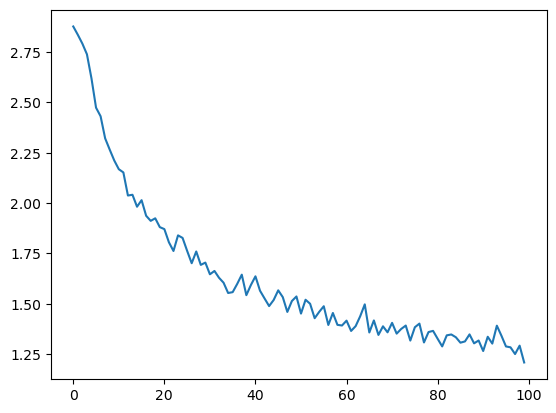

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

/tmp/ipykernel_2589/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_2589/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


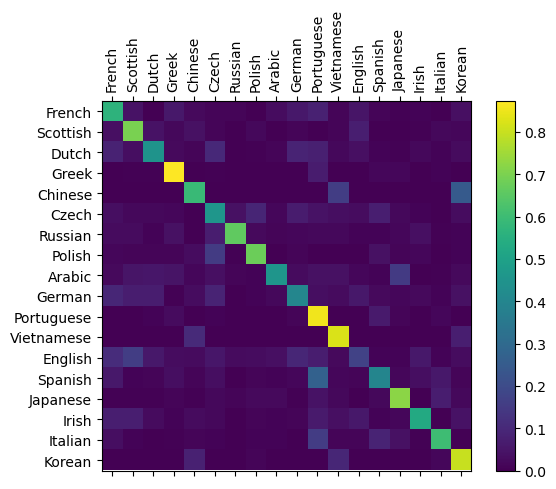

In [50]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()